https://colab.research.google.com/drive/1Ari5i5fR3do69W_aDrV0pjXnVvhLRRiv#scrollTo=vArH1YOl2E40

**Здесь реализована атака FGSM, где атакуется "белый ящик"(т.е. все внутрениие параметры модели известны), цель атаки - неправильная классификация (т.е. все равно в какой класс будет переклассифицирован объект, главное чтобы классификация была неверной).**

In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import torchvision as tv
from torch.utils.data import DataLoader
import time

In [ ]:
# ПРИМЕЧАНИЕ: Это хак, позволяющий обойти ограничения "User-agent" при загрузке наборов данных MNIST
#             см., https://github.com/pytorch/vision/issues/3497 для получения дополнительной информации
from six.moves import urllib
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [ ]:
model = Net()

In [ ]:
model

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

Смотрим какие веса в исходной модели и состояние градиента, он включен

In [ ]:
list(model.parameters())

[Parameter containing:
 tensor([[[[ 0.1860, -0.0037, -0.0007,  0.1096, -0.1583],
           [-0.0889,  0.0333, -0.0571, -0.0672, -0.1111],
           [-0.1772,  0.0929,  0.1259, -0.1122, -0.1898],
           [ 0.0738, -0.0479,  0.1571,  0.0336,  0.0618],
           [ 0.1722,  0.0220, -0.0040, -0.1807,  0.1642]]],
 
 
         [[[ 0.1399, -0.0876,  0.1836,  0.0543,  0.0599],
           [-0.1565,  0.0386,  0.1037,  0.0669,  0.0573],
           [-0.1375, -0.1104, -0.1319, -0.0423, -0.1741],
           [ 0.1886,  0.0747, -0.0104,  0.1799, -0.1703],
           [ 0.1309,  0.1526,  0.1484,  0.1142,  0.1343]]],
 
 
         [[[ 0.1427,  0.0622,  0.0573, -0.0286, -0.1849],
           [-0.1125, -0.1692,  0.1545, -0.0453, -0.1378],
           [-0.0754,  0.1843, -0.1840, -0.0027,  0.1922],
           [ 0.0883, -0.1428, -0.0295,  0.0647, -0.1419],
           [ 0.1254,  0.1632, -0.1613,  0.1417, -0.1030]]],
 
 
         [[[-0.1539, -0.0705,  0.0719,  0.0609,  0.1159],
           [-0.1013,  0.0413, -

In [ ]:
transform = tv.transforms.Compose([
              tv.transforms.Resize((28,28)),
              tv.transforms.ToTensor()
])

In [ ]:
mnist_train = tv.datasets.MNIST('.', train=True, transform=transform, download=True)
mnist_test  = tv.datasets.MNIST('.', train=False, transform=transform, download=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [ ]:
mnist_test

In [ ]:
mnist_train[1][0].shape

torch.Size([1, 28, 28])

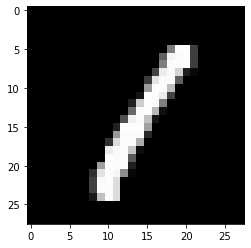

In [ ]:
plt.imshow(mnist_train[3][0].reshape(28, -1), cmap='gray', vmin=0, vmax=1)

In [ ]:
train_dataloader = DataLoader(mnist_train, batch_size=200, shuffle=True)
test_dataloader = DataLoader(mnist_test, batch_size=200, shuffle=True)

In [ ]:
# размораживаем все слои
for name, param in model.named_parameters():
 param.requires_grad = True

In [ ]:
# считает accuracy - берет данные прогоняет через модель и дает долю правильных ответов
def evaluate_accuracy(data_iter, net): #data_iter - картинка в виде тензора+метка, net-модель
    acc_sum, n = torch.Tensor([0]), 0 # acc_sum-тензор = 0, n=0 (счетчик типа)
    net.eval()
    for X, y in data_iter:
        acc_sum += (net(X).argmax(axis=1) == y).sum()
        # acc_sum - доля правильных ответов
        n += y.shape[0]
    return acc_sum.item() / n

In [ ]:
def train(net, train_iter, test_iter, trainer, num_epochs):
    loss = nn.CrossEntropyLoss(reduction='sum')
    net.train()
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, start = 0.0, 0.0, 0, time.time()
        for X, y in train_iter:
            trainer.zero_grad()
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            trainer.step()
            train_l_sum += l.item()
            train_acc_sum += (y_hat.argmax(axis=1) == y).sum().item()
            n += y.shape[0]
            print("Step. time since epoch: {:.3f}. Train acc: {:.3f}. Train Loss: {:.3f}".format(time.time() -  start,
                (y_hat.argmax(axis=1) == y).sum().item() / y.shape[0], l.item()))
        test_acc = evaluate_accuracy(test_iter, net)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f, '
              'time %.1f sec'
              % (epoch + 1, train_l_sum / n, train_acc_sum / n, test_acc,
                 time.time() - start))

In [ ]:
lr, num_epochs = 0.001, 5
trainer = torch.optim.SGD(model.parameters(), lr=lr)
train(model, train_dataloader, test_dataloader, trainer, num_epochs)

Step. time since epoch: 0.372. Train acc: 0.110. Train Loss: 461.087
Step. time since epoch: 0.472. Train acc: 0.105. Train Loss: 460.350
Step. time since epoch: 0.562. Train acc: 0.085. Train Loss: 462.902
Step. time since epoch: 0.671. Train acc: 0.115. Train Loss: 458.837
Step. time since epoch: 0.775. Train acc: 0.105. Train Loss: 457.214
Step. time since epoch: 0.883. Train acc: 0.140. Train Loss: 458.784
Step. time since epoch: 0.982. Train acc: 0.120. Train Loss: 458.755
Step. time since epoch: 1.073. Train acc: 0.130. Train Loss: 457.363
Step. time since epoch: 1.182. Train acc: 0.175. Train Loss: 453.026
Step. time since epoch: 1.282. Train acc: 0.175. Train Loss: 456.878
Step. time since epoch: 1.373. Train acc: 0.140. Train Loss: 455.508
Step. time since epoch: 1.481. Train acc: 0.200. Train Loss: 453.376
Step. time since epoch: 1.568. Train acc: 0.150. Train Loss: 451.202
Step. time since epoch: 1.653. Train acc: 0.225. Train Loss: 451.402
Step. time since epoch: 1.750. Tra

Смотрим какие веса в обученной модели.

In [ ]:
list(model.parameters())

[Parameter containing:
 tensor([[[[ 2.3049e-01,  8.6144e-02, -3.0039e-02,  2.6687e-03, -2.3419e-01],
           [-5.9729e-02,  1.0477e-01, -1.3373e-01, -2.4696e-01, -2.7026e-01],
           [-1.8242e-01,  1.5442e-01,  1.5642e-01, -1.4663e-01, -2.2417e-01],
           [ 6.0538e-02,  3.2303e-02,  3.4482e-01,  2.6461e-01,  2.2057e-01],
           [ 1.4416e-01,  7.4435e-02,  1.3470e-01,  3.9867e-02,  3.5313e-01]]],
 
 
         [[[ 6.8997e-02, -1.8696e-01,  8.6211e-02, -6.5262e-03,  2.6313e-03],
           [-1.1267e-01,  3.2480e-02,  1.0672e-01,  8.1662e-03, -4.0189e-02],
           [-6.2877e-02, -4.2325e-04,  1.1348e-02,  8.2351e-03, -2.2549e-01],
           [ 3.0243e-01,  3.2949e-01,  2.4226e-01,  2.8781e-01, -1.6511e-01],
           [ 2.8471e-01,  4.6500e-01,  4.3610e-01,  3.6602e-01,  3.4943e-01]]],
 
 
         [[[ 1.8038e-01,  1.1149e-01,  7.6655e-02, -4.1808e-02, -1.9330e-01],
           [-1.8475e-02, -6.2771e-02,  1.6763e-01, -7.8973e-02, -1.6037e-01],
           [ 3.7738e-02,  2.7

In [ ]:
# замораживаем все слои
for name, param in model.named_parameters():
 param.requires_grad = False

In [ ]:
torch.save(model.state_dict(), '/content/lmnist_model.pth')

# **Переобучаем модель в неправильную:**

In [ ]:
epsilons = [0, .05, .1, .15, .2, .25, .3]
pretrained_model = "/content/lmnist_model.pth"
use_cuda=True

In [ ]:
# Определение модели LeNet
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

# Тестовый набор данных MNIST и объявление dataloader
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ])),
        batch_size=1, shuffle=True)

# Определите, какое устройство мы используем
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

# Инициализируйте сеть
model = Net().to(device)

# Загрузите предварительно подготовленную модель
model.load_state_dict(torch.load(pretrained_model, map_location='cpu'))

# Переведите модель в режим оценки. В данном случае это для выпадающих слоев
model.eval()

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw

CUDA Available:  False


Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

# Атака FGSM

In [ ]:
# Код атаки
def fgsm_attack(image, epsilon, data_grad):
    # Соберите элементарный знак градиента данных
    sign_data_grad = data_grad.sign()
    # Создайте возмущенное изображение, настроив каждый пиксель входного изображения
    perturbed_image = image + epsilon*sign_data_grad
    # Добавление отсечения для сохранения [0,1]диапазон
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Возвращает возмущенное изображение
    return perturbed_image

# Функция тестирования

In [ ]:
def test( model, device, test_loader, epsilon ):

    # Счетчик точности
    correct = 0
    adv_examples = []

    # Перебор всех примеров в тестовом наборе
    for data, target in test_loader:

        # Отправка данных и метки в данные устройства
        data, target = data.to(device), target.to(device)

        # Включаем градиент для данных
        data.requires_grad = True

        # Делаем прямой проход
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # получить индекс максимальной логарифмической вероятности

        # Если начальное предсказание неверно, не утруждайте себя атакой, простопродолжайте
        if init_pred.item() != target.item():
            continue

        # Вычислить потери
        loss = F.nll_loss(output, target)

        # Обнуление всех существующих градиентов
        model.zero_grad()

        # Вычисление градиентов модели при обратном прохождении
        loss.backward()

        # Сбор данных градиента
        data_grad = data.grad.data

        # Вызов FGSM-атаки
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        # Переклассификация возмущенного изображенияoutput
        output = model(perturbed_data)

        # Проверка на успех
        final_pred = output.max(1, keepdim=True)[1] # получение индекса максимальной логарифмической вероятности
        if final_pred.item() == target.item():
            correct += 1
            # Особый случай для сохранения 0 эпсилонпримеры
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # Сохранить несколько примеров adv для визуализации позже
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # Вычислить конечную точность для этого epsilon
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    # Возвращает точность, а состязательный пример
    return final_acc, adv_examples

# Запустить атаку

In [ ]:
accuracies = []
examples = []

# Запускаум тест для каждого эпсилона
for eps in epsilons:
    acc, ex = test(model, device, test_loader, eps)
    accuracies.append(acc)
    examples.append(ex)

Epsilon: 0	Test Accuracy = 9868 / 10000 = 0.9868
Epsilon: 0.05	Test Accuracy = 9382 / 10000 = 0.9382
Epsilon: 0.1	Test Accuracy = 8107 / 10000 = 0.8107
Epsilon: 0.15	Test Accuracy = 5945 / 10000 = 0.5945
Epsilon: 0.2	Test Accuracy = 3443 / 10000 = 0.3443
Epsilon: 0.25	Test Accuracy = 1657 / 10000 = 0.1657
Epsilon: 0.3	Test Accuracy = 689 / 10000 = 0.0689


# Результаты:

# Точность против эпсилона

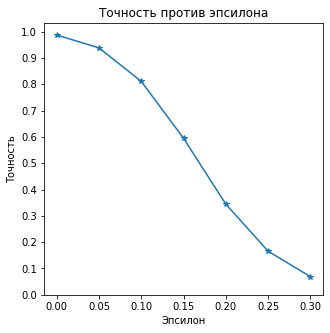

In [ ]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Точность против эпсилона")
plt.xlabel("Эпсилон")
plt.ylabel("Точность")
plt.show()

# Визуализация шума

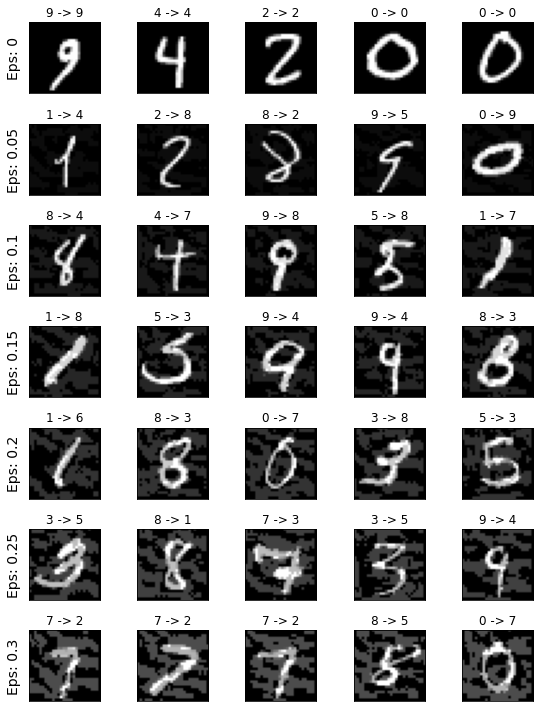

In [ ]:
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()